# NYU PUI HOMEWORK 11 - Part 1 - Subway Time Series Analysis
November 26, 2018

Author: zem232

## Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


### Task 1: 
Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
Identify it and figure out what it is due to.


### Task 2: 
Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


### Task 3: 
Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


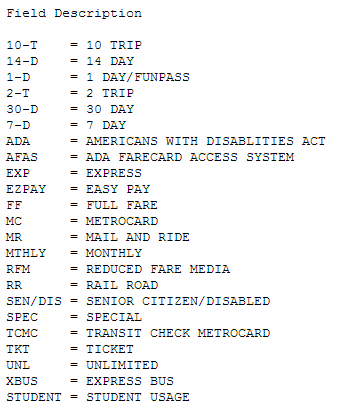

In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd
import os
import sys

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here: **refer to PUIDATA/MTA_Fare.npy**

you can load it as: np.load(“MTA_Fare.npy") and 

you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [2]:
mta = np.load(os.getenv('PUIDATA') + "/MTA_Fare.npy").astype(float)

In [3]:
mta [ mta < 0] = np.nan

In [4]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [5]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [6]:
Date = pd.date_range(start='05/19/2010', periods=194, freq='W')
MTA = pd.DataFrame(data = np.nansum(mta,axis=1), columns=Date).T


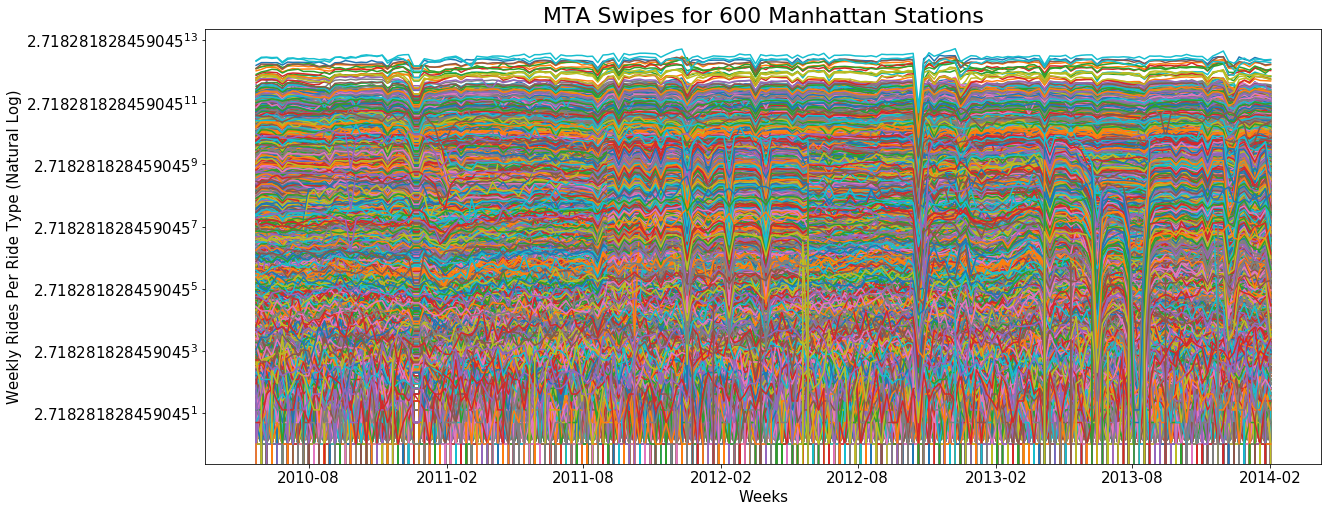

In [7]:
## Plotting the MTA swipes per ride type on a natural log scale
fig = plt.figure(figsize=(20,8))
for i in range(mta.shape[1]):
    plt.semilogy(Date,mta[:,i,:].T)
    plt.yscale('log',basey=e) 
plt.yticks(size=15)
plt.xticks(size=15)
plt.ylabel('Weekly Rides Per Ride Type (Natural Log)',size=15)
plt.xlabel('Weeks',size=15)
plt.title('MTA Swipes for 600 Manhattan Stations',size=22)
plt.show()

**Figure 1** This figure illustrates the weekly swipes experienced at 600 Manhattan Stations for 23 types of subway subscriptions (one day pass, monthly pass, etc.) illustrated on a natural log scale. This figure is nearly imposible to interpret, however it is clear that on certain days, a sharp decrease in ridership is observed across either many different stations and/or many types of ridership. 

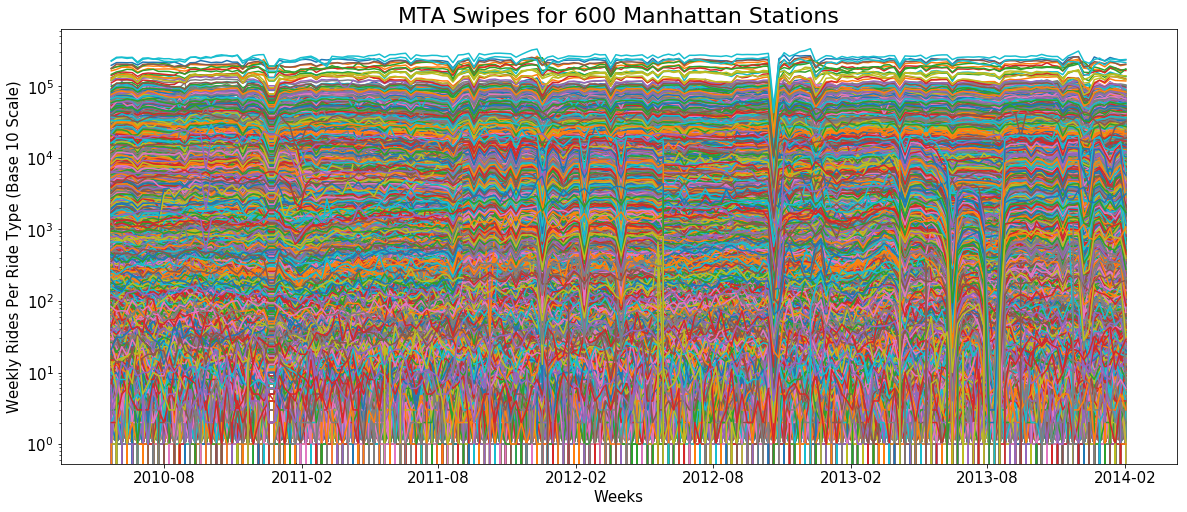

In [8]:
## Plotting MTA swipes on a log scale. 
fig = plt.figure(figsize=(20,8))
for i in range(mta.shape[1]):
    plt.semilogy(Date,mta[:,i,:].T)
    #plt.yscale('log',basey=e) 
plt.yticks(size=15)
plt.xticks(size=15)
plt.ylabel('Weekly Rides Per Ride Type (Base 10 Scale)', size=15)
plt.xlabel('Weeks',size=15)
plt.title('MTA Swipes for 600 Manhattan Stations',size=22)
plt.show()

**Figure 2** This figure illustrates the MTA swipes for 600 Manhattan stations plotted on a semi-log scale (base 10). This figure looks very similar to Figure 1, plotted on a semi-log scale (base e).

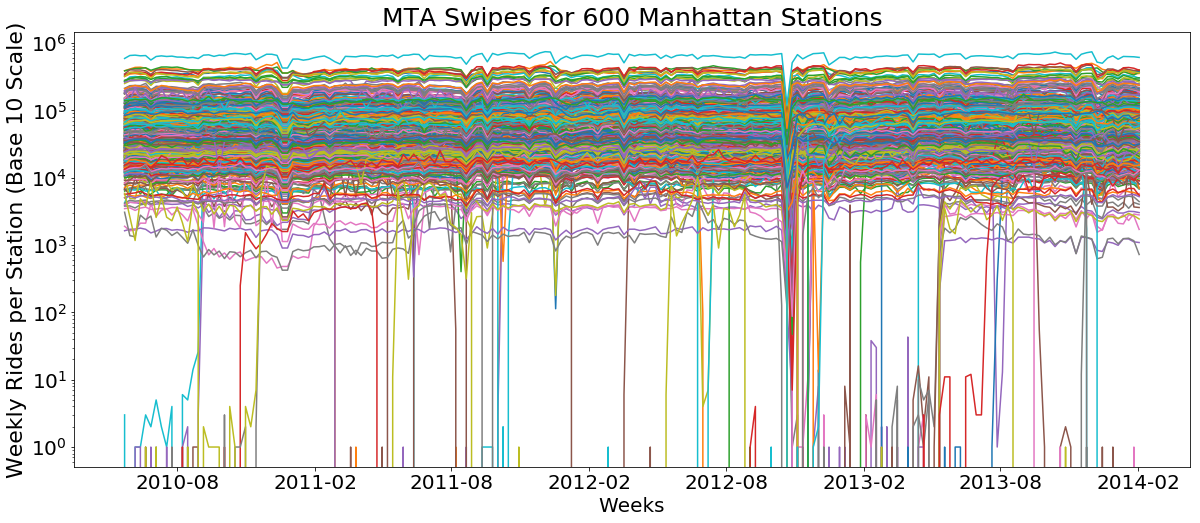

In [9]:
fig = plt.figure(figsize=(20,8))
plt.semilogy(MTA)
#plt.yscale('log') 
plt.yticks(size=20)
plt.xticks(size=20)
plt.title('MTA Swipes for 600 Manhattan Stations',size=25)
plt.ylabel('Weekly Rides per Station (Base 10 Scale)', size=22)
plt.xlabel('Weeks',size=20)
plt.show()

**Figure 3:** Time series for the sum of all ride types for 600 stations in Manhattan in a semi-log space (base 10). This figure illustrates that on certain days of the year, a decrease in ridership is observed across different stations. The most notable event occurred sometime around the end of 2012 (potentially New Years Eve or Christmas). 

# 1: Event Eetection 

Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [10]:
MTA=MTA[MTA>0]
MTA['Avg']=MTA.T.mean()

In [11]:
print ("mean ridership for all stations & ridetype {:.2f}".format(MTA['Avg'].mean()))
print ("stdev deaths by day {:.2f}".format(MTA['Avg'].std()))
threshold = [MTA['Avg'].mean() + 3 * MTA['Avg'].std(), 
              MTA['Avg'].mean() - 3 * MTA['Avg'].std()]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*threshold))

mean ridership for all stations & ridetype 64549.02
stdev deaths by day 6465.32
3-sigma thresholds 83944.98 45153.06


In [12]:
MTA.loc[(MTA['Avg'] < threshold[1])]

0   1       2       3       4       5       6       7  \
2012-10-21  20492.0 NaN  1108.0  3334.0  3564.0  3779.0  2202.0  1961.0   

                 8        9      ...       591  592  593  594  595  596  597  \
2012-10-21  2003.0  46761.0      ...       NaN  NaN  NaN  NaN  NaN  NaN  NaN   

            598  599           Avg  
2012-10-21  NaN  NaN  11344.969565  

[1 rows x 601 columns]

**Discussion** The most significant weekly drop in ridership for the average of all stations was 10/21/2012. This is probably due to the fact that Hurricane Sandy hit NYC that week.

In [13]:
thresholds = np.zeros((len(MTA.columns),2))
for k in (MTA.columns !='Avg'):
    thresholds[k] = [MTA[k].mean() + 3 * MTA[k].std(), 
              MTA[k].mean() - 3 * MTA[k].std()]

In [14]:
MTA.loc[(MTA[300] < thresholds[300][1])]

0   1       2       3       4       5       6       7  \
2012-10-21  20492.0 NaN  1108.0  3334.0  3564.0  3779.0  2202.0  1961.0   

                 8        9      ...       591  592  593  594  595  596  597  \
2012-10-21  2003.0  46761.0      ...       NaN  NaN  NaN  NaN  NaN  NaN  NaN   

            598  599           Avg  
2012-10-21  NaN  NaN  11344.969565  

[1 rows x 601 columns]

 # 2: Finding Trends

## NOTE ON THE TREND DETECTION:
You should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

To do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

You can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

Notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [16]:
MTA_rt = pd.DataFrame(data = np.nansum(mta,axis=0), columns=Date, index=ridetype).T
MTA_rt = MTA_rt[MTA_rt>0]
print ("MTA array shape averaged over all stations:", shape(MTA_rt))

MTA array shape averaged over all stations: (194, 23)


In [17]:
MTA_rt = MTA_rt/MTA_rt.mean()

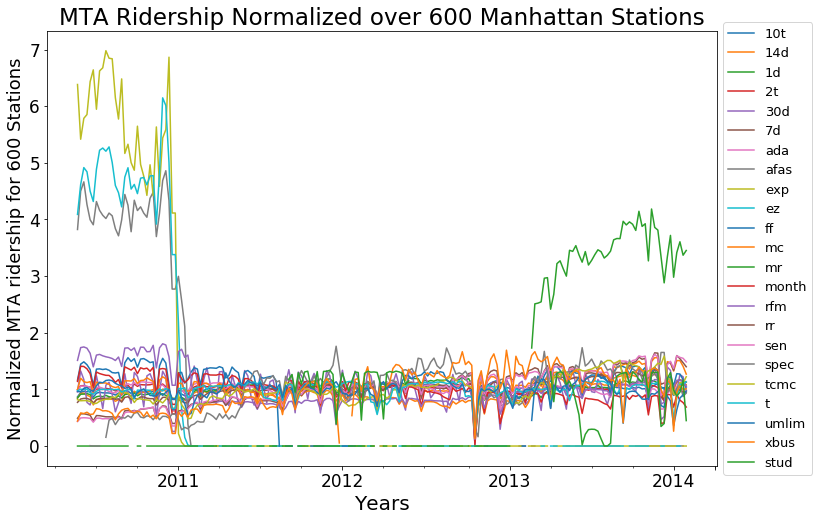

In [18]:
## Visualizing the timeseries for ridership type, normalized over 600 Manhattan Stations.
ax = MTA_rt.plot(figsize=(12,8), fontsize=17);
ax.set_xlabel("Years", fontsize=20)
ax.set_ylabel('Normalized MTA ridership for 600 Stations',fontsize=18)
ax.set_title('MTA Ridership Normalized over 600 Manhattan Stations',fontsize=23)
ax.legend(fontsize=13, loc='center left', bbox_to_anchor=(1, 0.5))

<Figure size 432x288 with 0 Axes>

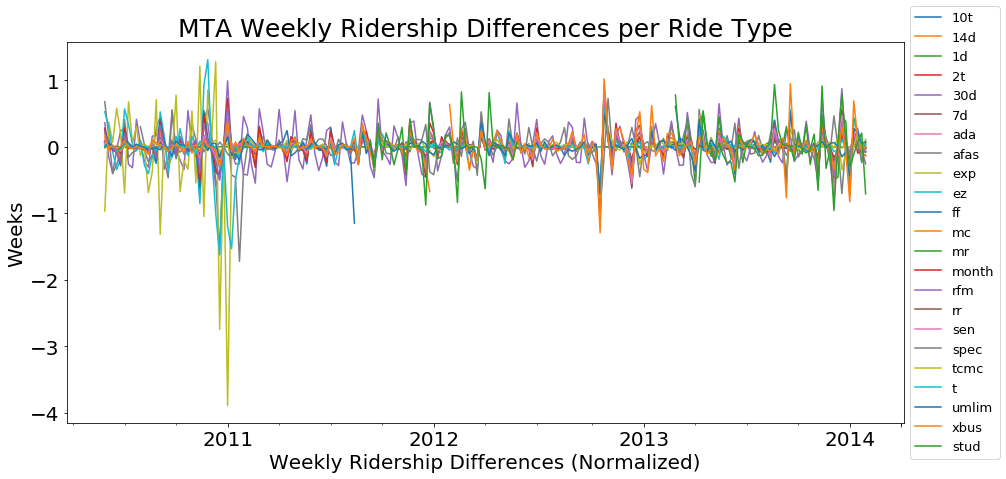

In [39]:
pl.figure()
ax2 = MTA_rt.diff(periods=1).plot(figsize=(15,7), fontsize=20)
ax2.set_xlabel('Weekly Ridership Differences (Normalized)', fontsize=20)
ax2.set_ylabel('Weeks', fontsize=20)
ax2.set_title('MTA Weekly Ridership Differences per Ride Type',fontsize=25)
ax2.legend(fontsize=13, loc='center left', bbox_to_anchor=(1, 0.5));

In [35]:
a.index[0]

'exp'

In [41]:
a = MTA_rt.diff(periods=1).abs().max().sort_values(ascending=False)
print('The ridership type that experienced the sharpest decline is: %s'%(a.index[0]))
print('Top ridership types with sharpest changes & relative magnitude: \n\n',a.head())

The ridership type that experienced the sharpest decline is: exp
Top ridership types with sharpest changes & relative magnitude: 

 exp     3.892784
afas    1.724238
ez      1.628064
xbus    1.295066
ff      1.149030
dtype: float64


# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [45]:
label = mta
label.shape

(600, 23, 194)

In [46]:
label[:26]

array([[[5.6961e+04, 6.4703e+04, 6.8002e+04, ..., 3.6527e+04,
         3.3929e+04, 3.6824e+04],
        [1.7320e+03, 2.0830e+03, 2.1070e+03, ..., 1.2640e+03,
         1.1720e+03, 1.2380e+03],
        [2.0300e+02, 2.7600e+02, 2.4500e+02, ..., 1.8600e+02,
         1.6700e+02, 1.6700e+02],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [       nan,        nan,        nan, ..., 1.1210e+03,
         1.3770e+03, 7.1200e+02]],

       [[1.6210e+04, 2.0179e+04, 2.1769e+04, ...,        nan,
                nan,        nan],
        [5.0300e+02, 6.4700e+02, 6.6500e+02, ...,        nan,
                nan,        nan],
        [4.1000e+01, 4.3000e+01, 4.4000e+01, ...,        nan,
                nan,        nan],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ...,        nan,
                nan,        nan],
        [0.0

In [ ]:
stationsmeans = ...
stationsmeans.shape

In [ ]:
stationsstd = ...
stationsstd.shape

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [ ]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid[mta.reshape(600*23, 194).std(1) > 0]

In [ ]:
tots = mta.reshape....
tots.shape

In [ ]:
normed_time_series_mean = ...
normed_time_series_std = ...

In [ ]:
normed_time_series_std[:10]

In [ ]:
tsmean = np.nanmean(tots, axis=1)
tsmean.shape



In [ ]:
tsmean[:10]

In [ ]:
tsstdev[:10]


In [ ]:
standardizedts = ...
for i in range(10):
    pl.plot(standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [ ]:
allfits = sm.OLS...
[a.params[0] for a in allfits[:10]]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(ts)/normedtsmean, np.std(ts)/normedtsstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

In [ ]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [ ]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

In [ ]:
X_train[~np.isfinite(X_train)] = # ... make a choice about what to do with this datapoint. drop it or replace it with something

In [ ]:
clf = rfc()...

and use sklearn confusion_matrix to see the errors

In [ ]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [ ]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    ...

In [ ]:
imshow(confusion_matrix(y_test, y_pred))

In [ ]:
print(classification_report(y_test, y_pred, target_names=ridetype))